In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import torch
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, roc_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from transformers import ElectraForSequenceClassification, ElectraTokenizerFast
from transformers import BertConfig
from transformers import TFSequenceSummary
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from torch.optim import AdamW

In [3]:
data0 = pd.read_csv('/content/drive/MyDrive/Makale-29-4-23/Dataset0.csv')
data1 = pd.read_csv('/content/drive/MyDrive/Makale-29-4-23/Dataset1.csv')
data2 = pd.read_csv('/content/drive/MyDrive/Makale-29-4-23/Dataset2.csv')
data3 = pd.read_csv('/content/drive/MyDrive/Makale-29-4-23/Dataset3.csv')
data4 = pd.read_csv('/content/drive/MyDrive/Makale-29-4-23/Dataset4.csv')
data5 = pd.read_csv('/content/drive/MyDrive/Makale-29-4-23/Dataset5.csv')

In [4]:
def Metrics(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  pr = precision_score(y_test, y_pred)
  rc = recall_score(y_test, y_pred)
  kappa = cohen_kappa_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  return cm, acc, f1, pr, rc, kappa, auc, fpr, tpr, thresholds

In [5]:
def Tokenize(tweets, labels, tokenizer):
  input_ids = []
  attention_masks = []
  for tweet in tweets:
    encoded_dict = tokenizer.encode_plus(
                        tweet,                    
                        add_special_tokens = True, 
                        max_length = 512, # tokenizer.model_max_length,          
                        padding='max_length',
                        return_attention_mask = True,   
                        return_tensors = 'pt',
                        truncation=True,    
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  return input_ids, attention_masks, labels

In [6]:
def ret_dataloader():
    batch_size = config["batch_size"]
    print('batch_size = ', batch_size)
    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = RandomSampler(train_dataset), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )
    validation_dataloader = DataLoader(
                valid_dataset, # The validation samples.
                sampler = SequentialSampler(valid_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )
    test_dataloader = DataLoader(
                test_dataset, # The validation samples.
                sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )
    return train_dataloader,validation_dataloader, test_dataloader

In [7]:
def ret_model(tl_model):
  if tl_model == 'electra':
    model = ElectraForSequenceClassification.from_pretrained("google/electra-base-discriminator", num_labels = 2, ignore_mismatched_sizes=True)
  return model

In [8]:
def ret_optim(model):
    print('Learning_rate = ', config["learning_rate"] )
    optimizer = AdamW(model.parameters(),
                      lr = config["learning_rate"], 
                      eps = 1e-8 
                    )
    return optimizer

In [9]:
def ret_scheduler(train_dataloader,optimizer):
    epochs = config["epochs"]
    print('epochs =>', epochs)
   
    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    return scheduler

In [10]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [11]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [12]:
torch.multiprocessing.set_start_method('spawn', force=True)

In [13]:
def Run(tl_model):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = ret_model(tl_model)
  model.to(device)
  train_dataloader,validation_dataloader, test_dataloader = ret_dataloader()
  optimizer = ret_optim(model)
  scheduler = ret_scheduler(train_dataloader,optimizer)
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  #torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  training_stats = []

  total_t0 = time.time()
  epochs = config["epochs"]

  for epoch_i in tqdm(range(0, epochs)):

    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        output = model(b_input_ids, 
                               token_type_ids=None,
                               attention_mask=b_input_mask, 
                               labels=b_labels)         
        loss = output[0]
        logits = output[1] 
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    # wandb.log({'avg_train_loss':avg_train_loss})

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
       
        with torch.no_grad():        
            output = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            loss = output[0]
            logits = output[1] 
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
        # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    # wandb.log({'val_accuracy':avg_val_accuracy,'avg_val_loss':avg_val_loss})
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

  print("")
  print("Training complete!")
  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  return model

In [14]:
X = data0.processed_tweet.values
y = data0.label_enc.values

In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [16]:
print(f"X TRAIN: {len(X_train)}")
print(f"X VALIDATION: {len(X_valid)}")
print(f"X TEST: {len(X_test)}")
print(f"Y TRAIN: {len(y_train)}")
print(f"Y VALIDATION: {len(y_valid)}")
print(f"Y TEST: {len(y_test)}")

X TRAIN: 7490
X VALIDATION: 1605
X TEST: 1605
Y TRAIN: 7490
Y VALIDATION: 1605
Y TEST: 1605


In [17]:
tokenizer_electra = ElectraTokenizerFast.from_pretrained("google/electra-base-discriminator", do_lower_case=True)

In [18]:
config = {
    'learning_rate': 1e-5,
    'batch_size': 32,
    'epochs':10
}

In [19]:
tr_input_ids, tr_attention_masks, y_train = Tokenize(X_train, y_train, tokenizer_electra)
vl_input_ids, vl_attention_masks, y_valid = Tokenize(X_valid, y_valid, tokenizer_electra)
ts_input_ids, ts_attention_masks, y_test = Tokenize(X_test, y_test, tokenizer_electra)

In [20]:
train_dataset = TensorDataset(tr_input_ids, tr_attention_masks, y_train)
valid_dataset = TensorDataset(vl_input_ids, vl_attention_masks, y_valid)
test_dataset = TensorDataset(ts_input_ids, ts_attention_masks, y_test)
print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(valid_dataset)))
print('{:>5,} test samples'.format(len(test_dataset)))

7,490 training samples
1,605 validation samples
1,605 test samples


In [21]:
model_electra = Run('electra')

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.o

batch_size =  32
Learning_rate =  1e-05
epochs => 10


  0%|          | 0/10 [00:00<?, ?it/s]


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    235.    Elapsed: 0:00:30.
  Batch    80  of    235.    Elapsed: 0:00:58.
  Batch   120  of    235.    Elapsed: 0:01:25.
  Batch   160  of    235.    Elapsed: 0:01:52.
  Batch   200  of    235.    Elapsed: 0:02:19.

  Average training loss: 0.39
  Training epoch took: 0:02:42

Running Validation...
  Accuracy: 0.91
  Validation Loss: 0.24
  Validation took: 0:00:11

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    235.    Elapsed: 0:00:27.
  Batch    80  of    235.    Elapsed: 0:00:54.
  Batch   120  of    235.    Elapsed: 0:01:21.
  Batch   160  of    235.    Elapsed: 0:01:49.
  Batch   200  of    235.    Elapsed: 0:02:16.

  Average training loss: 0.23
  Training epoch took: 0:02:39

Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.21
  Validation took: 0:00:11

======== Epoch 3 / 10 ========
Training...
  Batch    40  of    235.    Elapsed: 0:00:27.
  Batch    80  of    235.    Elapsed: 0:00:54

In [22]:
def Electra_test(X_test):
  y_pred = []
  for i in range(len(X_test)):
    tweet = X_test[i]
    inputs = tokenizer_electra(tweet, return_tensors="pt", max_length=512, truncation=True)
    inputs.to('cuda')
    res = model_electra(**inputs)
    if res[0].tolist()[0][0] < 0:
      y_pred.append(1)
    else:
      y_pred.append(0)
  return y_pred

In [23]:
y_pred=Electra_test(X_test)

Accuracy:  0.9439252336448598
F1 Score:  0.9479768786127166


<Axes: >

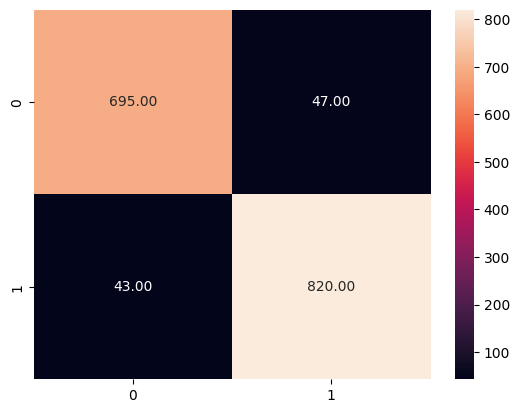

In [24]:
cm_el, acc_el, f1_el, pr_el, rc_el, kappa_el, auc_el, fpr_el, tpr_el, th_el = Metrics(y_test, y_pred) 
print("Accuracy: ", acc_el)
print("F1 Score: ", f1_el)
sns.heatmap(cm_el, annot=True, fmt='.2f')

In [25]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn import tree

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
def MLPip(mla):
  pipeline = Pipeline([
      ('bow', CountVectorizer()),  
      ('tfidf', TfidfTransformer()),
      ('c', mla)])
  pipeline.fit(X_train, y_train)
  return pipeline

Accuracy:  0.9289719626168225
F1 Score:  0.933411214953271


<Axes: >

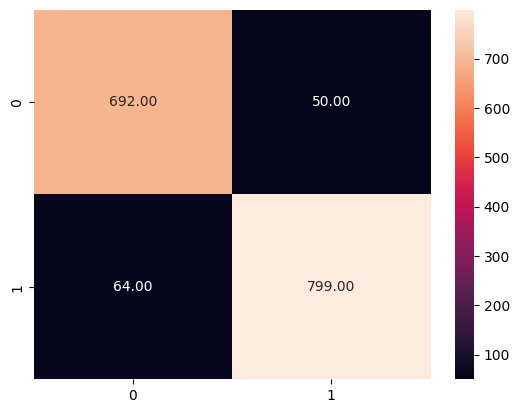

In [28]:
pipelineSVC = MLPip(SVC())
y_pred_svc = pipelineSVC.predict(X_test)

cm_svc, acc_svc, f1_svc, pr_svc, rc_svc, kappa_svc, auc_svc, fpr_svc, tpr_svc, th_svc = Metrics(y_test, y_pred_svc) 
print("Accuracy: ", acc_svc)
print("F1 Score: ", f1_svc)
sns.heatmap(cm_svc, annot=True, fmt='.2f')

Accuracy:  0.8411214953271028
F1 Score:  0.8516579406631763


<Axes: >

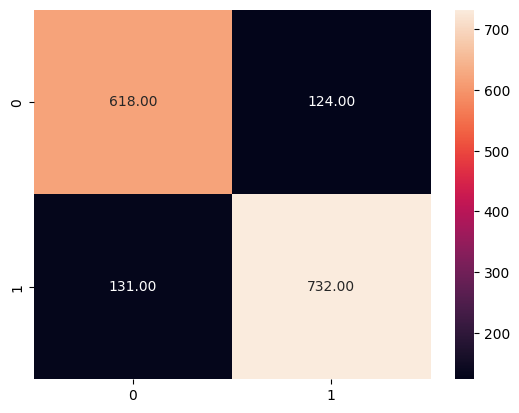

In [30]:
pipelineDT = MLPip(tree.DecisionTreeClassifier())
y_pred_dt = pipelineDT.predict(X_test)

cm_dt, acc_dt, f1_dt, pr_dt, rc_dt, kappa_dt, auc_dt, fpr_dt, tpr_dt, th_dt = Metrics(y_test, y_pred_dt) 
print("Accuracy: ", acc_dt)
print("F1 Score: ", f1_dt)
sns.heatmap(cm_dt, annot=True, fmt='.2f')

Accuracy:  0.908411214953271
F1 Score:  0.9130691898285039


<Axes: >

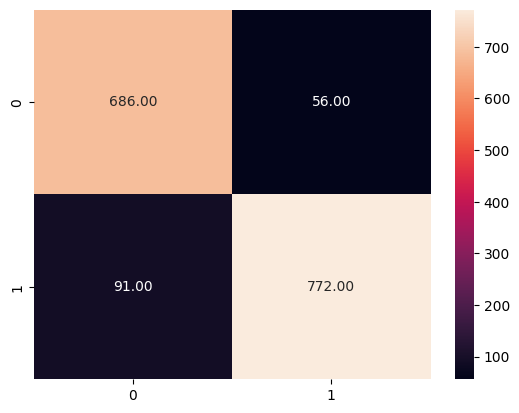

In [32]:
pipelineRF = MLPip(RandomForestClassifier())
y_pred_rf = pipelineRF.predict(X_test)

cm_rf, acc_rf, f1_rf, pr_rf, rc_rf, kappa_rf, auc_rf, fpr_rf, tpr_rf, th_rf = Metrics(y_test, y_pred_rf) 
print("Accuracy: ", acc_rf)
print("F1 Score: ", f1_rf)
sns.heatmap(cm_rf, annot=True, fmt='.2f')

Accuracy:  0.8897196261682243
F1 Score:  0.8947055324211779


<Axes: >

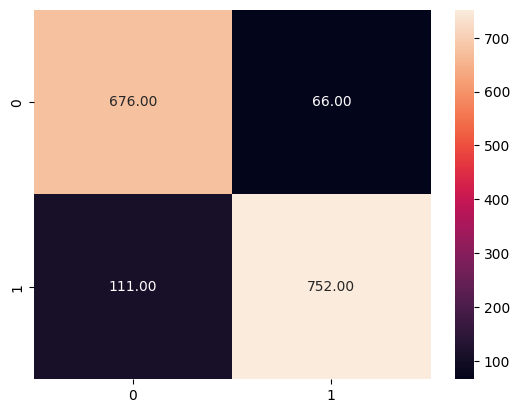

In [33]:
pipelineXGB = MLPip(xgb.XGBClassifier())
y_pred_xgb = pipelineXGB.predict(X_test)

cm_xgb, acc_xgb, f1_xgb, pr_xgb, rc_xgb, kappa_xgb, auc_xgb, fpr_xgb, tpr_xgb, th_xgb = Metrics(y_test, y_pred_xgb) 
print("Accuracy: ", acc_xgb)
print("F1 Score: ", f1_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='.2f')

Accuracy:  0.9090342679127725
F1 Score:  0.9160919540229885


<Axes: >

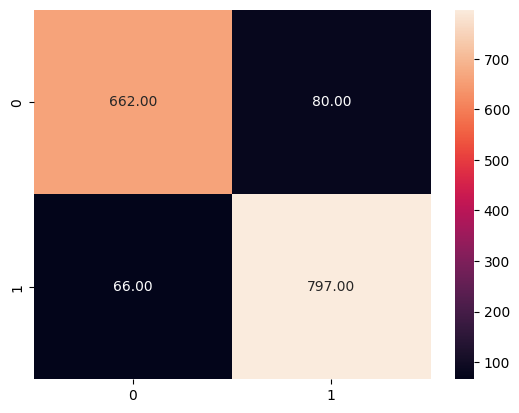

In [35]:
pipelineKNN = MLPip(KNeighborsClassifier())
y_pred_knn = pipelineKNN.predict(X_test)

cm_knn, acc_knn, f1_knn, pr_knn, rc_knn, kappa_knn, auc_knn, fpr_knn, tpr_knn, th_knn = Metrics(y_test, y_pred_knn) 
print("Accuracy: ", acc_knn)
print("F1 Score: ", f1_knn)
sns.heatmap(cm_knn, annot=True, fmt='.2f')

In [36]:
models = pd.DataFrame({
    'Model': ['Electra', 'Support Vector Machines', 'Decision Tree',  'Random Forest', 'XGBoost', 'KNN'],
    'Accuracy': [acc_el, acc_svc, acc_dt, acc_rf, acc_xgb, acc_knn],
    'Precision': [pr_el*100, pr_svc*100, pr_dt*100, pr_rf*100, pr_xgb*100, pr_knn*100],
    'Recall': [rc_el*100, rc_svc*100, rc_dt*100, rc_rf*100, rc_xgb*100, rc_knn*100],
    'Roc Auc': [auc_el*100, auc_svc*100, auc_dt*100, auc_rf*100, auc_xgb*100, auc_knn*100],
    'F1 Score': [f1_el*100, f1_svc*100, f1_dt*100, f1_rf*100, f1_xgb*100, f1_knn*100],
    'Cohen Kappa Score': [kappa_el*100, kappa_svc*100, kappa_dt*100, kappa_rf*100, kappa_xgb*100, kappa_knn*100]})
models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,Roc Auc,F1 Score,Cohen Kappa Score
0,Electra,0.943925,94.579008,95.017381,94.341575,94.797688,88.716677
1,Support Vector Machines,0.928972,94.110718,92.584009,92.922732,93.341121,85.732065
5,KNN,0.909034,90.877993,92.352260,90.785294,91.609195,81.678627
3,Random Forest,0.908411,93.236715,89.455388,90.954109,91.306919,81.638256
4,XGBoost,0.889720,91.931540,87.137891,89.121506,89.470553,77.911762
2,Decision Tree,0.841121,85.514019,84.820394,84.054402,85.165794,68.063789


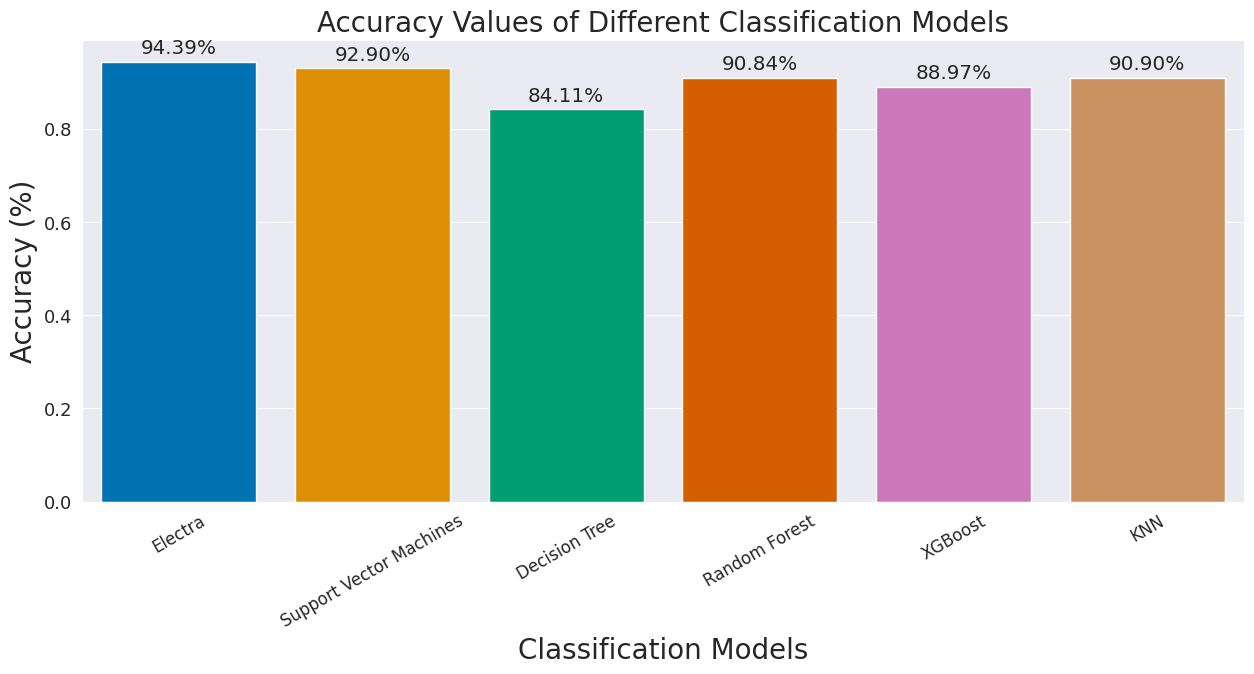

In [37]:
plt.rcParams['figure.figsize']=15,6 
sns.set_style("darkgrid")
ax = sns.barplot(x=models.Model, y=models.Accuracy, palette = "colorblind", saturation =1.5)
plt.xlabel("Classification Models", fontsize = 20 )
plt.ylabel("Accuracy (%)", fontsize = 20)
plt.title("Accuracy Values of Different Classification Models", fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 30)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

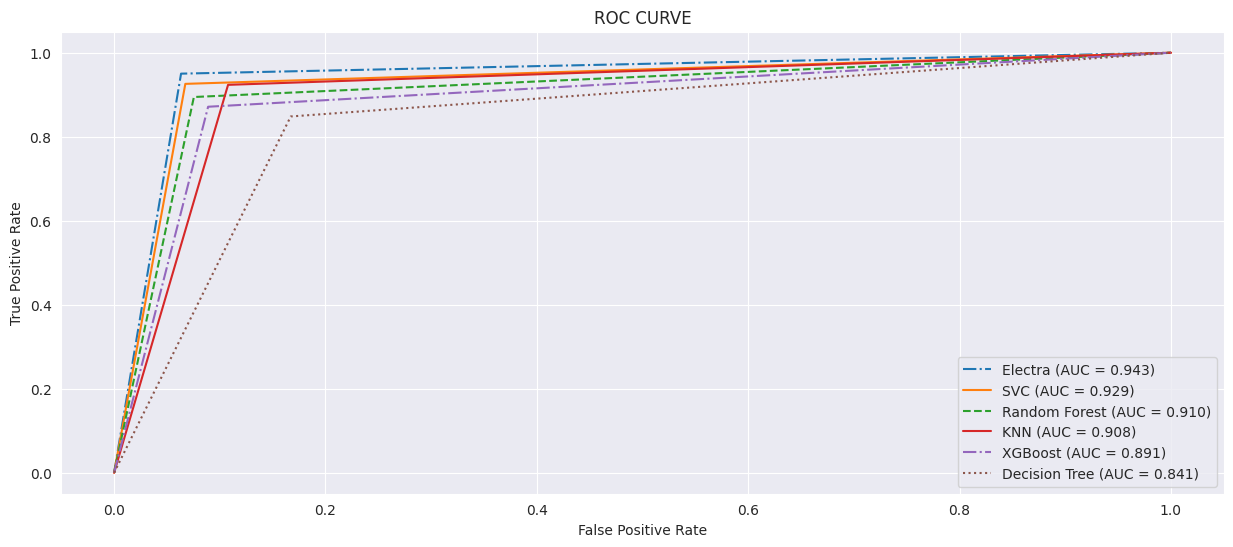

In [38]:
plt.plot(fpr_el, tpr_el, linestyle='-.', label='Electra (AUC = %.3f)' % auc_el)
plt.plot(fpr_svc, tpr_svc, linestyle='-', label='SVC (AUC = %.3f)' % auc_svc)
plt.plot(fpr_rf, tpr_rf, linestyle='--', label='Random Forest (AUC = %.3f)' % auc_rf)
plt.plot(fpr_knn, tpr_knn, linestyle='solid', label='KNN (AUC = %.3f)' % auc_knn)
plt.plot(fpr_xgb, tpr_xgb, linestyle='dashdot', label='XGBoost (AUC = %.3f)' % auc_xgb)
plt.plot(fpr_dt, tpr_dt, linestyle=':', label='Decision Tree (AUC = %.3f)' % auc_dt)
plt.title('ROC CURVE')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()